# Preparing the Data

### Importing the necessary libraries needed to obtain a clean CSV file that contains the Mouse_ID, Total Microglial Count for the Mouse, the Dose of the Mouse, and the Sex of the mouse.

In [27]:
import pandas as pd
import glob
import re
from pathlib import Path

#### Find all 'Total Counts' CSV files

In [28]:
# find all CSV files

project = Path.cwd().parents[1]
data_dir = project / "01_data" / "01_raw" / "Total Counts"
file_list = sorted(data_dir.glob("*.csv"))

print("Found", len(file_list), "CSV files")

Found 35 CSV files


#### Created a function that will take the QuPath exported CSV files and build a clean CSV files that contains the Mouse ID, Microglial Counts, Dose Levels, and Sex of the mouse. 

#### For each CSV file, the fuction reads the data and only keeps rows where Classification='Iba1', extracts the Mouse ID from the Image column. The function then aggregates rows by Mouse ID to compute Microglial Count, attaches the predefined Dose and Sex for each mouse, and warns you if any IDs aren't in the mapping. Finally, the cleaned CSV is saved and returns the DataFrame.

In [29]:
from pathlib import Path
import pandas as pd
import re

def build_clean_microglial_counts_from_files(
    file_list,
    out_csv: str | Path = "01_data/02_clean/final_microglial_counts_cleaned.csv",
    verbose: bool = True,
) -> pd.DataFrame:
    """
    Inputs:
    file_list : list of CSV file paths 
    out_csv   : where to save the cleaned CSV 
    verbose   : print progress/warnings

    What the function does:
    1) Read each CSV
    2) Keeps only rows with Classification == 'Iba1'
    3) Ensure an image-name column exists ('Image'); if missing, try common alternates or fallback to filename.
    4) Extract Mouse_ID from the image name using the first 'HH####' pattern.
    5) Count rows per Mouse_ID => 'Microglial_Count'.
    6) Map 'Dose' and 'Sex' from the fixed dictionaries below.
    7) Save the clean CSV file to out_csv and return it.

    Output columns: 
    ['Mouse_ID', 'Microglial_Count', 'Dose', 'Sex']
    """

    # dose and sex mappings
    female_dose = {
        'HH2639': 0,  'HH2640': 0,  'HH2641': 0,  'HH2642': 0,
        'HH3030': 100,'HH3031': 100,'HH3032': 100,'HH3033': 100,
        'HH3412': 300,'HH3413': 300,'HH3414': 300,'HH3415': 300,
        'HH4072': 600,'HH4073': 600,'HH4075': 600,
        'HH4699': 900,'HH4700': 900,'HH4701': 900,'HH4702': 900,
        'HH4721':1200,'HH4722':1200,'HH4723':1200,'HH4724':1200}
    male_dose = {
        'HH2649': 0,  'HH2650': 0,  'HH2651': 0,  'HH2652': 0,
        'HH4717': 900,'HH4718': 900,'HH4719': 900,'HH4720': 900,
        'HH4725':1200,'HH4726':1200,'HH4727':1200,'HH4728':1200}

    dose_mapping = {**female_dose, **male_dose}
    sex_mapping  = {**{k: "Female" for k in female_dose}, **{k: "Male" for k in male_dose}}

    # basic checks
    if not file_list:
        raise ValueError("file_list is empty. Pass a non-empty list of CSV file paths.")

    # get Mouse_ID like 'HH2639' from image text
    def extract_mouse_id(text: str) -> str:
        s = "" if pd.isna(text) else str(text)
        m = re.search(r"HH\d+", s)
        return m.group(0) if m else s

    parts: list[pd.DataFrame] = []

    #  read each CSV, keep only Iba1 rows, ensure image column
    for fp in file_list:
        try:
            df = pd.read_csv(fp, low_memory=False)  # avoids DtypeWarning
        except Exception as e:
            if verbose: print(f"[skip] {fp}: read error → {e}")
            continue

        if "Classification" not in df.columns:
            if verbose: print(f"[skip] {fp}: missing 'Classification' column")
            continue

        # keep only rows labeled exactly 'Iba1' 
        keep = df[df["Classification"] == "Iba1"].copy()
        if keep.empty:
            continue

        # ensured image-name column available to extract IDs from
        if "Image" not in keep.columns:
            if 'Image Name' in keep.columns:
                keep = keep.rename(columns={"Image Name": "Image"})
            else:
                raise KeyError(f"{fp} has no 'Image' (or 'Image Name') column.")

        parts.append(keep)

    if not parts:
        raise RuntimeError("No rows with Classification == 'Iba1' were found in the provided files.")

    # combine all kept rows, derive Mouse_ID, and count per mouse
    combined = pd.concat(parts, ignore_index=True)
    combined["Mouse_ID"] = combined["Image"].apply(extract_mouse_id)

    summary = (
        combined.groupby("Mouse_ID")
        .size()
        .reset_index(name="Microglial_Count")
        .sort_values("Mouse_ID")
        .reset_index(drop=True))

    # map Dose and Sex
    summary["Dose"] = summary["Mouse_ID"].map(dose_mapping)
    summary["Sex"]  = summary["Mouse_ID"].map(sex_mapping)

    # save to CSV
    out_csv = Path(out_csv)
    if out_csv.suffix.lower() != ".csv":
        out_csv = out_csv / "final_microglial_counts_cleaned.csv"
    out_csv.parent.mkdir(parents=True, exist_ok=True)
    summary.to_csv(out_csv, index=False)
    if verbose:
        print(f"Saved Clean CSV")

    return summary


In [30]:
# creating the output location for the cleaned CSV file

clean_dir = project /"01_data" / "02_clean" # folder path where the CSV file will reside
clean_csv = clean_dir / "final_microglial_counts_cleaned.csv" # file path to the output CSV
clean_dir.mkdir(parents=True, exist_ok=True) # creates folder if it doesn't exist

In [31]:
# running the function to create the clean CSV file and previewing the DataFrame
clean_df = build_clean_microglial_counts_from_files(
    file_list=file_list,
    out_csv=clean_csv,
    verbose=True)

clean_df.head()

Saved Clean CSV


,Mouse_ID,Microglial_Count,Dose,Sex
0,HH2639,6376,0,Female
1,HH2640,2650,0,Female
2,HH2641,3833,0,Female
3,HH2642,5837,0,Female
4,HH2649,7897,0,Male


# Visualizations

## Code used to generate visualizations for the microglial counts for all mice.

### Importing the necessary libraries needed to generate visulaziations to display microglial counts. 

In [32]:
import matplotlib.pyplot as plt
import seaborn as sns

### Generating Visualizations for the Female Mice

#### Strip Plot for Female Mice

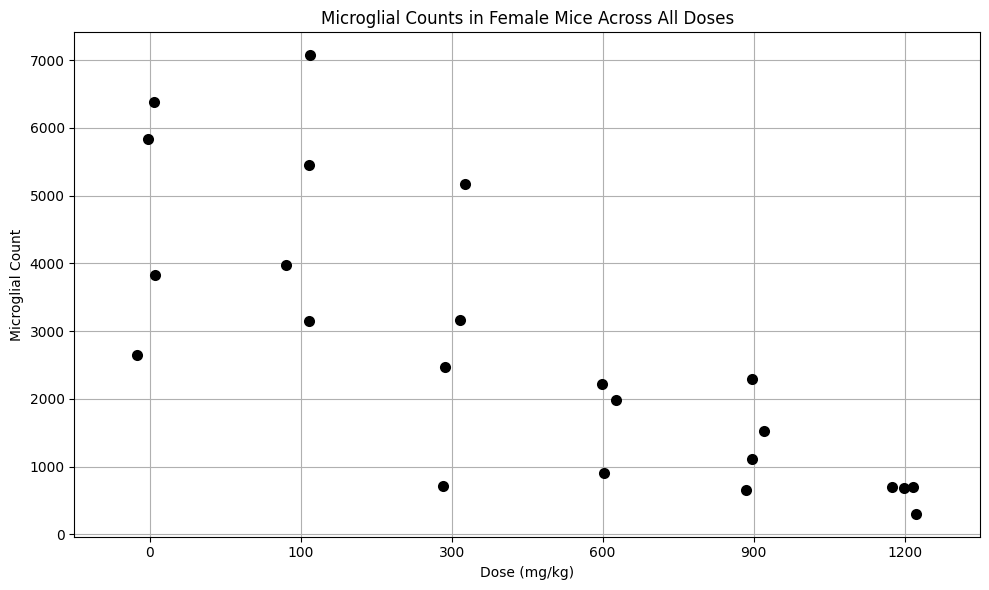

In [33]:
# filter for only female mice
female_df = clean_df[clean_df["Sex"] == "Female"]
# where the visual will be saved
save_dir = project /"02_analysis" / "04_visualizations" / "counts"
save_dir.mkdir(parents=True, exist_ok=True)
fig_path = save_dir / "female_counts_strip.png"

# creating a strip plot for female mice
plt.figure(figsize=(10, 6))
sns.stripplot(data=female_df, x='Dose', y='Microglial_Count', color='black', size=8)
plt.title("Microglial Counts in Female Mice Across All Doses")
plt.xlabel("Dose (mg/kg)")
plt.ylabel("Microglial Count")
plt.grid(True)
plt.tight_layout()

plt.savefig(fig_path, dpi=300)

#### Point Plot for Female Mice

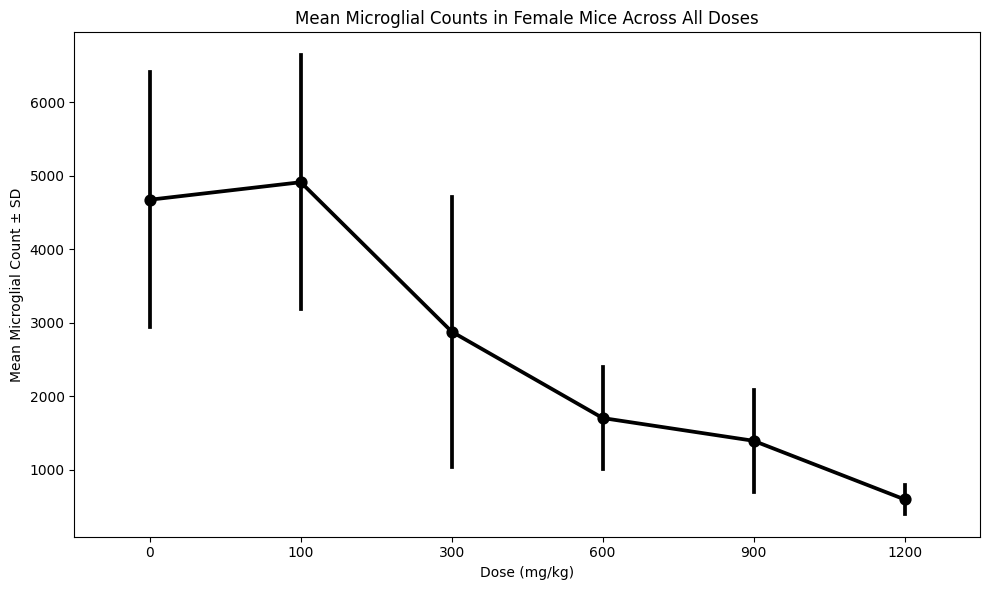

In [34]:
# where the visual will be saved
save_dir = project /"02_analysis" / "04_visualizations" / "counts"
save_dir.mkdir(parents=True, exist_ok=True)
fig_path = save_dir / "female_counts_point.png"

# creating a point plot for female mice
plt.figure(figsize=(10, 6))
sns.pointplot(data=female_df, 
              x='Dose', 
              y='Microglial_Count',
              color='black', 
              errorbar='sd', 
              markers='o', 
              linestyles='-')

plt.title("Mean Microglial Counts in Female Mice Across All Doses")
plt.xlabel("Dose (mg/kg)")
plt.ylabel("Mean Microglial Count ± SD")
plt.tight_layout()

plt.savefig(fig_path, dpi=300)

### Generating Visualizations for the Male Mice

#### Strip Plot for Male Mice

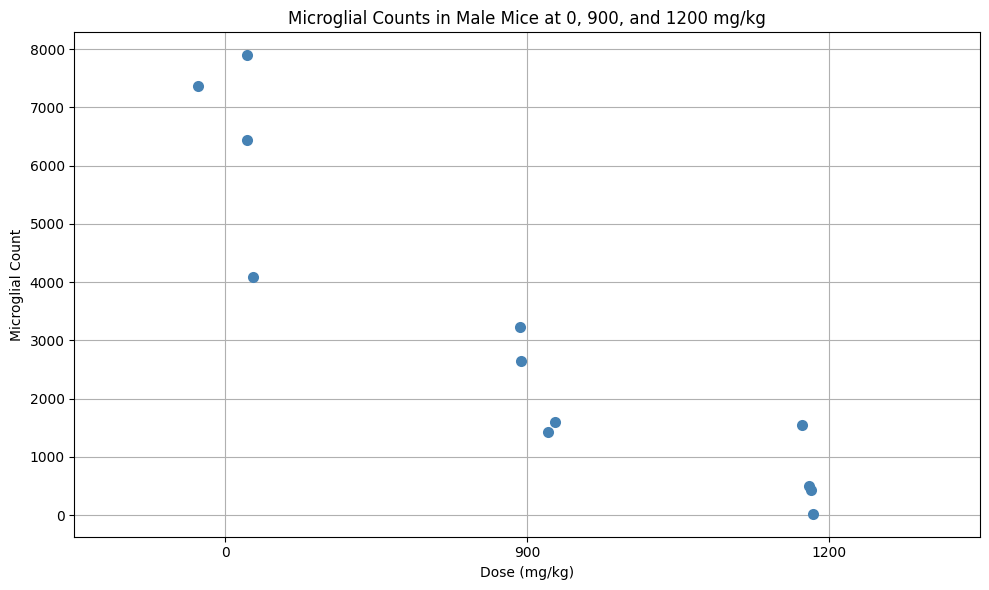

In [35]:
# filter for only male mice
male_df = clean_df[clean_df["Sex"] == "Male"]
# where the visual will be saved
save_dir = project /"02_analysis" / "04_visualizations" / "counts"
save_dir.mkdir(parents=True, exist_ok=True)
fig_path = save_dir / "male_counts_strip.png"

plt.figure(figsize=(10, 6))
sns.stripplot(data=male_df, x='Dose', y='Microglial_Count', color='steelblue', size=8)

plt.title("Microglial Counts in Male Mice at 0, 900, and 1200 mg/kg")
plt.xlabel("Dose (mg/kg)")
plt.ylabel("Microglial Count")
plt.grid(True)
plt.tight_layout()
plt.savefig(fig_path, dpi=300)

#### Point Plot for Male Mice

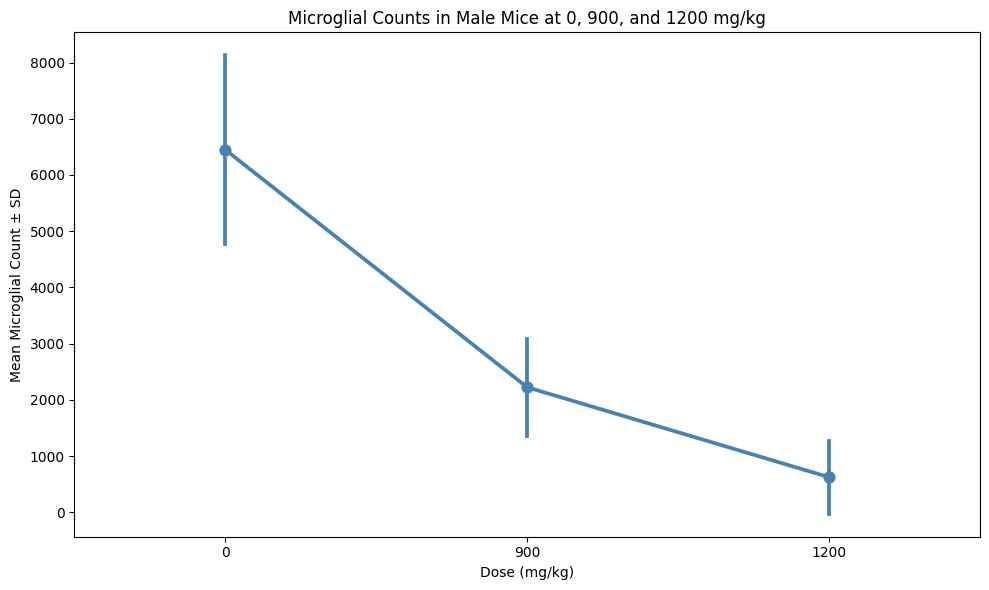

In [36]:
# where the visual will be saved
save_dir = project /"02_analysis" / "04_visualizations" / "counts"
save_dir.mkdir(parents=True, exist_ok=True)
fig_path = save_dir / "male_counts_point.png"

# creating a point plot for male mice
plt.figure(figsize=(10, 6))
sns.pointplot(data=male_df, 
              x='Dose', 
              y='Microglial_Count',
              color='steelblue', 
              errorbar='sd', 
              markers='o', 
              linestyles='-')

plt.title("Microglial Counts in Male Mice at 0, 900, and 1200 mg/kg")
plt.xlabel("Dose (mg/kg)")
plt.ylabel("Mean Microglial Count ± SD")
plt.tight_layout()

plt.savefig(fig_path, dpi=300)